# Monte Carlo simulator
By: Magnus Kvåle Helliesen

# *Under construction*

In [43]:
import pandas as pd
import numpy as np
from numpy.linalg import eig, inv
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

Suppose we have a matrix of data $X=\{x_t\}_{t=0}^{T-1}$, where $x_t=(x_{1,t}, x_{2,t}, \ldots, x_{N,t})$ is a vector of variabels at time $t$.

In [44]:
class MonteCarlo():
    def __init__(self, df: pd.DataFrame):
        self._df = df

    @property
    def df(self):
        return self._df

    def _find_eig(self):
        array = self.df.to_numpy()

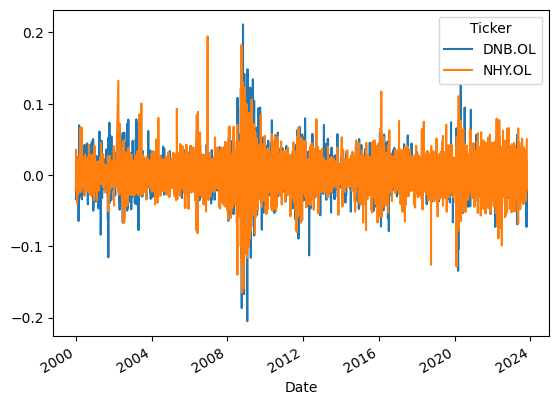

In [45]:
data = {}
for ticker in ['NHY.OL', 'DNB.OL']:
    data[ticker] = yf.Ticker(ticker).history(period='max')

df = (
    pd.concat(data)[['Close']]
    .reset_index()
    .rename(columns={'level_0': 'Ticker'})
    .pivot(index='Date', columns='Ticker', values='Close')
)
np.log(df).diff().plot()
plt.show()

In [66]:
df_diff = np.log(df).diff().dropna()

In [76]:
model = arch_model(df_diff['DNB.OL'], vol='garch', p=1, o=0, q=1, rescale=False)

In [77]:
fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 7536198563.965583
Iteration:      2,   Func. Count:     19,   Neg. LLF: 480670494.98181945
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15501.622470997285
            Iterations: 2
            Function evaluations: 29
            Gradient evaluations: 2


<Axes: xlabel='Date'>

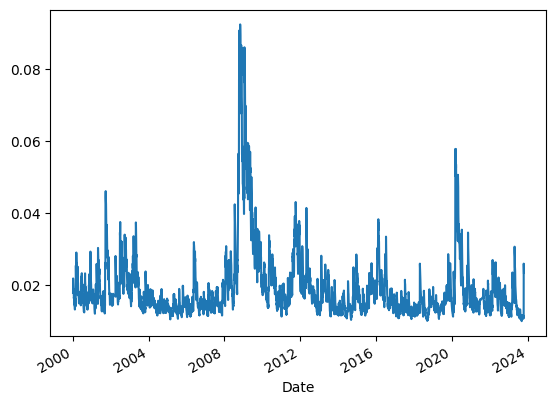

In [78]:
fit.conditional_volatility.plot()